In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces

from sklearn.preprocessing import LabelEncoder

In [3]:
import chardet
# 파일의 인코딩 감지
with open('/content/drive/MyDrive/강화학습/기말프로젝트/foodData.csv', 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']
encoding

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'EUC-KR'

In [4]:
data = pd.read_csv("/content/drive/MyDrive/강화학습/기말프로젝트/foodData.csv", encoding='EUC-KR')
data

,응답일시,참여자,"오늘 기분을 골라주세요. 1점 최악, 10점 최고(*)",현재의 날씨를 골라주세요.(*),"자신이 느끼는 현재의 온도를 골라주세요. 1점 추움, 10점 더움(*)",시간과 관계없이 현재 자신이 느끼는 식사 시간대를 선택해주세요.(*),함께 밥을 먹을 인원수를 입력해주세요.(*),성별을 골라주세요.(*),"나이대를 입력해주세요. (19살 -> 1, 20살 -> 2)(*)","현재의 날씨, 기분, 온도 그리고 인원수를 포함하여 먹고싶거나 먹기로 한 메뉴를 입력해주세요. (띄어쓰기X)(*)",기프티콘 지급을 위한 연락처를 입력해주세요. (필수 X)
0,2024-05-21 15:38:15,1,4,맑음,10,저녁(석식),2명,남자,2,제육볶음,1.040628e+09
1,2024-05-21 15:38:51,2,8,맑음,10,점심(중식),4명,여자,2,마라탕,1.032130e+09
2,2024-05-21 15:41:52,3,6,맑음,5,점심(중식),1명,여자,2,떡볶이,1.075212e+09
3,2024-05-21 15:42:51,4,3,맑음,3,저녁(석식),2명,여자,2,닭볶음탕,1.050636e+09
4,2024-05-21 15:44:22,5,10,맑음,5,점심(중식),4명,여자,5,스파게티,1.035316e+09
...,...,...,...,...,...,...,...,...,...,...,...
238,2024-06-04 23:16:24,208,8,맑음,3,저녁(석식),3명,여자,2,족발,1.043776e+09
239,2024-06-04 23:27:23,209,6,맑음,7,점심(중식),1명,여자,2,치킨,1.043776e+09
240,2024-06-04 23:27:50,210,6,맑음,5,저녁(석식),1명,여자,2,김치볶음밥,1.043776e+09
241,2024-06-05 02:42:20,211,2,맑음,4,야식,5명 이상,남자,2,라면,1.055484e+09


In [5]:
data.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['응답일시', '참여자', '오늘 기분을 골라주세요. 1점 최악, 10점 최고(*)', '현재의 날씨를 골라주세요.(*)',
       '자신이 느끼는 현재의 온도를 골라주세요. 1점 추움, 10점 더움(*)',
       '시간과 관계없이 현재 자신이 느끼는 식사 시간대를 선택해주세요.(*)', '함께 밥을 먹을 인원수를 입력해주세요.(*)',
       '성별을 골라주세요.(*)', '나이대를 입력해주세요. (19살 -> 1, 20살 -> 2)(*)',
       '현재의 날씨, 기분, 온도 그리고 인원수를 포함하여 먹고싶거나 먹기로 한 메뉴를 입력해주세요. (띄어쓰기X)(*)',
       '기프티콘 지급을 위한 연락처를 입력해주세요. (필수 X)'],
      dtype='object')

In [6]:
del data['응답일시']
del data['참여자']
del data['나이대를 입력해주세요. (19살 -> 1, 20살 -> 2)(*)']
del data['기프티콘 지급을 위한 연락처를 입력해주세요. (필수 X)']
data

,"오늘 기분을 골라주세요. 1점 최악, 10점 최고(*)",현재의 날씨를 골라주세요.(*),"자신이 느끼는 현재의 온도를 골라주세요. 1점 추움, 10점 더움(*)",시간과 관계없이 현재 자신이 느끼는 식사 시간대를 선택해주세요.(*),함께 밥을 먹을 인원수를 입력해주세요.(*),성별을 골라주세요.(*),"현재의 날씨, 기분, 온도 그리고 인원수를 포함하여 먹고싶거나 먹기로 한 메뉴를 입력해주세요. (띄어쓰기X)(*)"
0,4,맑음,10,저녁(석식),2명,남자,제육볶음
1,8,맑음,10,점심(중식),4명,여자,마라탕
2,6,맑음,5,점심(중식),1명,여자,떡볶이
3,3,맑음,3,저녁(석식),2명,여자,닭볶음탕
4,10,맑음,5,점심(중식),4명,여자,스파게티
...,...,...,...,...,...,...,...
238,8,맑음,3,저녁(석식),3명,여자,족발
239,6,맑음,7,점심(중식),1명,여자,치킨
240,6,맑음,5,저녁(석식),1명,여자,김치볶음밥
241,2,맑음,4,야식,5명 이상,남자,라면


In [7]:
menu_list = data['현재의 날씨, 기분, 온도 그리고 인원수를 포함하여 먹고싶거나 먹기로 한 메뉴를 입력해주세요. (띄어쓰기X)(*)'].unique()
menu_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['제육볶음', '마라탕', '떡볶이', '닭볶음탕', '스파게티', '항정살덮밥', '족발', '돈가스', '삼겹살',
       '파스타', '하와이안피자', '크림파스타', '피자', '김치찌개', '불고기피자', '회', '덮밥', '타코야끼',
       '닭강정', '야끼소바', '초밥', '짜장면', '고구마피자', '제육덮밥', '치킨', '자장면', '소곱창',
       '바나나 한개', '밥버거', '냉면', '고기', '낙곱새', '고등어회', '봉구스밥버거', '닭발', '닭갈비',
       '페퍼로니피자', '김치전', '1명 닭꼬치', '순두부찌개', '청국장', '돼지고기김치찜', '닭우동', '사케동',
       '무뼈닭발', '간장치킨', '요거트아이스크림', '분짜', '샌드위치', '소고기무국', '돼지갈비', '짜파게티',
       '곱창', '양꼬치', '라면', '열무국수', '닭꼬치', '양송이수프', '소고기덮밥', '해장국', '순대국밥',
       '선지해장국', '소바', '부대찌개', '스테이크', '새우초밥', '비빔국수', '불닭게티', '된장찌개',
       '고구마치즈돈가스', '투움바파스타', '양념치킨', '대창', '솥밥', '연어회', '파전', '육회', '칼국수',
       '전', '로제마라샹궈', '두부김치', '강된장보리밥', '백반', '바게트', '막국수', '포케',
       '치킨, 고기, 막걸리, 파전, 샐러드', '연어초밥', '연어덮밥', '멘보샤', '콩나물국밥육개장', '추어탕',
       '허니콤보', '설렁탕', '쌀국수', '국밥', '로제떡볶이', '마라떡볶이', '돼지국밥', '화채', '갈비탕',
       '씨리얼', '불고기백반', '회덮밥', '치즈돈까스', '쫄면', '햄버거', '마제소바', '쭈꾸미볶음',
       '닭똥집튀김', '냉소바', '순대국', '직화고기', '유부초밥', '김치볶음밥', 

In [8]:
data.columns = ['feeling','weather','temp','time','num_people','gender','menu']
data.columns

Index(['feeling', 'weather', 'temp', 'time', 'num_people', 'gender', 'menu'], dtype='object')

In [9]:
data

,feeling,weather,temp,time,num_people,gender,menu
0,4,맑음,10,저녁(석식),2명,남자,제육볶음
1,8,맑음,10,점심(중식),4명,여자,마라탕
2,6,맑음,5,점심(중식),1명,여자,떡볶이
3,3,맑음,3,저녁(석식),2명,여자,닭볶음탕
4,10,맑음,5,점심(중식),4명,여자,스파게티
...,...,...,...,...,...,...,...
238,8,맑음,3,저녁(석식),3명,여자,족발
239,6,맑음,7,점심(중식),1명,여자,치킨
240,6,맑음,5,저녁(석식),1명,여자,김치볶음밥
241,2,맑음,4,야식,5명 이상,남자,라면


In [10]:
menu_list = data['menu']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
label_encoder = LabelEncoder()

# 각 범주형 컬럼에 Label Encoding 적용
categorical_columns = ['weather', 'time', 'gender', 'menu']  # 범주형 컬럼 목록
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])
data['num_people'] = data['num_people'].str.extract('(\d+)').astype(int)
# 변환된 데이터 확인
print(data.head())

   feeling  weather  temp  time  num_people  gender  menu
0        4        3    10     2           2       0    85
1        8        3    10     3           4       1    36
2        6        3     5     3           1       1    31
3        3        3     3     2           2       1    21
4       10        3     5     3           4       1    68


<>:7: DeprecationWarning: invalid escape sequence '\d'


In [12]:
menu_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("메뉴 이름과 매핑된 정수:")
print(menu_mapping)

메뉴 이름과 매핑된 정수:
{'1명 닭꼬치': 0, '간장치킨': 1, '갈비탕': 2, '강된장보리밥': 3, '고구마치즈돈가스': 4, '고구마피자': 5, '고기': 6, '고등어회': 7, '곱창': 8, '국밥': 9, '김치볶음밥': 10, '김치전': 11, '김치찌개': 12, '낙곱새': 13, '냉면': 14, '냉소바': 15, '닭갈비': 16, '닭강정': 17, '닭꼬치': 18, '닭똥집튀김': 19, '닭발': 20, '닭볶음탕': 21, '닭우동': 22, '대창': 23, '덮밥': 24, '돈가스': 25, '돼지갈비': 26, '돼지고기김치찜': 27, '돼지국밥': 28, '된장찌개': 29, '두부김치': 30, '떡볶이': 31, '라면': 32, '로제떡볶이': 33, '로제마라샹궈': 34, '마라떡볶이': 35, '마라탕': 36, '마제소바': 37, '막국수': 38, '멘보샤': 39, '무뼈닭발': 40, '바게트': 41, '바나나 한개': 42, '밥버거': 43, '백반': 44, '봉구스밥버거': 45, '부대찌개': 46, '분짜': 47, '불고기백반': 48, '불고기피자': 49, '불닭게티': 50, '비빔국수': 51, '사케동': 52, '삼각김밥': 53, '삼겹살': 54, '새우초밥': 55, '샌드위치': 56, '선지해장국': 57, '설렁탕': 58, '소고기덮밥': 59, '소고기무국': 60, '소곱창': 61, '소바': 62, '솥밥': 63, '순대국': 64, '순대국밥': 65, '순두부찌개': 66, '스테이크': 67, '스파게티': 68, '쌀국수': 69, '씨리얼': 70, '야끼소바': 71, '양꼬치': 72, '양념치킨': 73, '양송이수프': 74, '연어덮밥': 75, '연어초밥': 76, '연어회': 77, '열무국수': 78, '요거트아이스크림': 79, '유부초밥': 80, '육회': 81, '자장면': 82, '전': 83, '제육덮밥':

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
len(menu_mapping)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


116

In [14]:
data

,feeling,weather,temp,time,num_people,gender,menu
0,4,3,10,2,2,0,85
1,8,3,10,3,4,1,36
2,6,3,5,3,1,1,31
3,3,3,3,2,2,1,21
4,10,3,5,3,4,1,68
...,...,...,...,...,...,...,...
238,8,3,3,2,3,1,86
239,6,3,7,3,1,1,96
240,6,3,5,2,1,1,10
241,2,3,4,1,5,0,32


In [15]:
breakfast_data = data[data['time'] == 0]
lunch_data = data[data['time'] == 1]
dinner_data = data[data['time'] == 2]
Midnight_data = data[data['time'] == 3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
d_episodes = []
for i in range(max(len(breakfast_data), len(lunch_data), len(dinner_data), len(Midnight_data))):
    episode = [
        breakfast_data.iloc[i % len(breakfast_data)].tolist(),
        lunch_data.iloc[i % len(lunch_data)].tolist(),
        dinner_data.iloc[i % len(dinner_data)].tolist(),
        Midnight_data.iloc[i % len(Midnight_data)].tolist()
    ]
    d_episodes.append(episode)

In [24]:
d_episodes[0]

[[7, 3, 5, 0, 4, 0, 89],
 [6, 3, 6, 1, 1, 0, 101],
 [4, 3, 10, 2, 2, 0, 85],
 [8, 3, 10, 3, 4, 1, 36]]

In [25]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [26]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)
        self.epsilon = 1.0  # 초기 탐색 확률
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        if random.random() < self.epsilon:
            action = random.randrange(len(menu_mapping))  # 무작위 행동 선택
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
            action = q_values.max(1)[1].item()  # 최대 Q 값을 가진 행동 선택
        return action

    def update_model(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        max_next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * 0.99 * max_next_q_values

        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 탐색 확률 감소
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [27]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [43]:
a = agent.replay_buffer.sample(10)

In [44]:
a

[([7, 3, 7, 1, 1, 1], 40, 1, [6, 5, 8, 2, 4, 0], False),
 ([10, 3, 10, 2, 2, 0], 96, 1, [10, 0, 8, 3, 1, 0], True),
 ([7, 3, 6, 1, 1, 1], 87, -1, [8, 4, 3, 2, 3, 1], False),
 ([5, 5, 4, 1, 3, 0], 11, 1, [7, 5, 7, 2, 2, 1], False),
 ([5, 5, 4, 1, 3, 0], 11, 1, [9, 3, 6, 2, 1, 1], False),
 ([4, 6, 4, 2, 1, 1], 36, -1, [8, 3, 8, 3, 1, 1], True),
 ([7, 5, 6, 0, 1, 1], 56, 1, [7, 3, 6, 1, 1, 1], False),
 ([4, 7, 8, 1, 4, 1], 86, -1, [7, 0, 7, 2, 4, 1], False),
 ([8, 3, 8, 2, 1, 0], 96, 1, [5, 6, 6, 3, 2, 0], True),
 ([7, 3, 8, 0, 1, 0], 14, 1, [4, 7, 8, 1, 4, 1], False)]

In [45]:
s,a,r,n,d = zip(*a)

In [46]:
d

(False, True, False, False, False, True, False, False, True, False)

In [47]:
agent.replay_buffer.sample(1)

[([4, 3, 6, 0, 1, 0], 70, 1, [4, 7, 8, 1, 4, 1], False)]

In [32]:
# state_dim = 6  # 상태 차원 (예시)
# action_dim = len(menu_mapping)  # 행동 차원 (예시, 추천할 메뉴 수)
# replay_buffer = ReplayBuffer(10000)
# agent = DQNAgent(state_dim, action_dim, replay_buffer)
# batch_size = 16

# # 가정: `env`는 학습 환경으로, 초기 상태를 반환하는 `reset()`과
# # 주어진 행동에 따라 다음 상태, 보상, 종료 여부를 반환하는 `step(action)` 메소드를 제공
# # 또한 `target_menus`는 각 상태에 따른 정답 메뉴의 리스트라고 가정

# episodes = 100000
# reward_arr = []
# for episode in range(episodes):
#     day_data = d_episodes[episode%len(d_episodes)]
#     total_reward = 0

#     for i in range(len(day_data) - 1):
#         state = day_data[i][:-1]
#         next_state = day_data[i + 1][:-1]
#         target_menu = day_data[i][-1]

#         action = agent.select_action(state)
#         reward = 1 if action == target_menu else -1
#         done = (i == len(day_data) - 2)

#         agent.replay_buffer.push(state, action, reward, next_state, done)
#         agent.update_model(batch_size)

#         state = next_state
#         total_reward += reward
#     reward_arr.append(total_reward)
#     if episode % 10000 == 0:
#         print(f"Episode {episode}, Total Reward: {total_reward}")
#         torch.save(agent.model.state_dict(), f"/content/drive/MyDrive/강화학습/기말프로젝트/model_{episode}.pth")
#     elif episode % 10000 == 0:
#         print(f"Episode {episode}, Total Reward: {total_reward}")

In [33]:
state_dim = 6  # 상태 차원 (예시)
action_dim = len(menu_mapping)  # 행동 차원 (예시, 추천할 메뉴 수)
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(state_dim, action_dim, replay_buffer)
batch_size = 16

episodes = 100000
reward_arr = []
for episode in range(episodes):
    day_data = d_episodes[episode%len(d_episodes)]
    total_reward = 0

    for i in range(len(day_data) - 1):
        state = day_data[i][:-1]
        next_state = day_data[i + 1][:-1]
        target_menu = day_data[i][-1]

        action = agent.select_action(state)
        reward = 1 if action == target_menu else -1
        done = (i == len(day_data) - 2)

        agent.replay_buffer.push(state, action, reward, next_state, done)
        # state = next_state
        total_reward += reward

    agent.update_model(batch_size)
    reward_arr.append(total_reward)
    if episode % 10000 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")
        torch.save(agent.model.state_dict(), f"/content/drive/MyDrive/강화학습/기말프로젝트/model_{episode}.pth")
    elif episode % 10000 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

Episode 0, Total Reward: -3
Episode 10000, Total Reward: -1
Episode 20000, Total Reward: -3
Episode 30000, Total Reward: 1
Episode 40000, Total Reward: 1
Episode 50000, Total Reward: -1
Episode 60000, Total Reward: 1
Episode 70000, Total Reward: 3
Episode 80000, Total Reward: 1
Episode 90000, Total Reward: 3


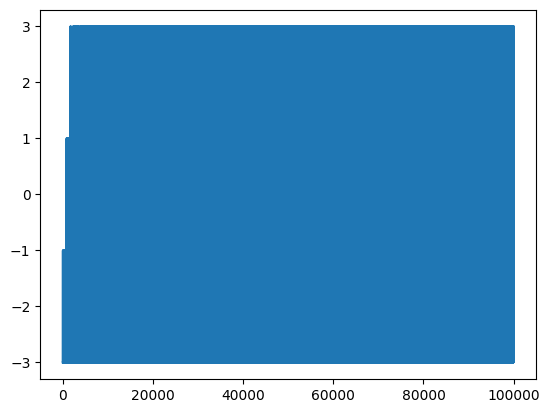

In [34]:
plt.plot(reward_arr)

In [35]:
np.mean(reward_arr[500:1000])

-2.772

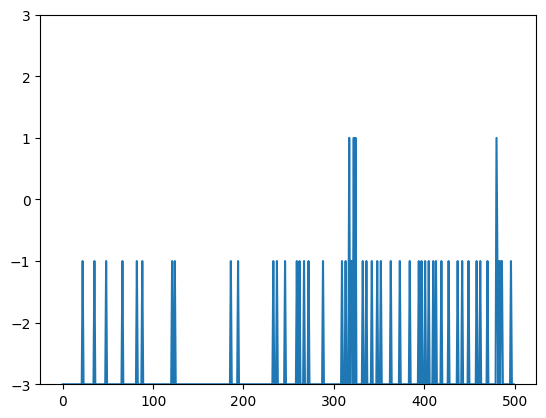

In [36]:
plt.ylim(-3, 3)
plt.plot(reward_arr[500:1000])

In [37]:
np.mean(reward_arr[19500:20000])

0.072

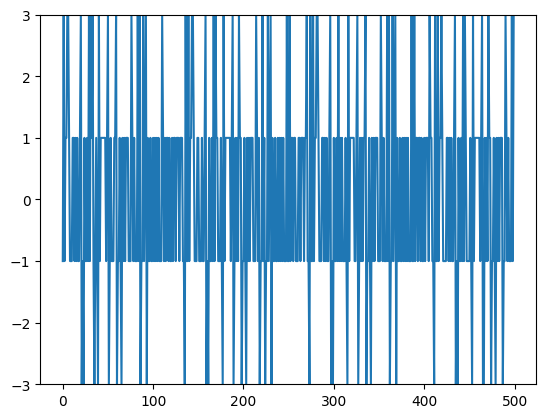

In [38]:
plt.ylim(-3, 3)
plt.plot(reward_arr[19500:20000])

In [39]:
np.mean(reward_arr[49500:50000])

0.48

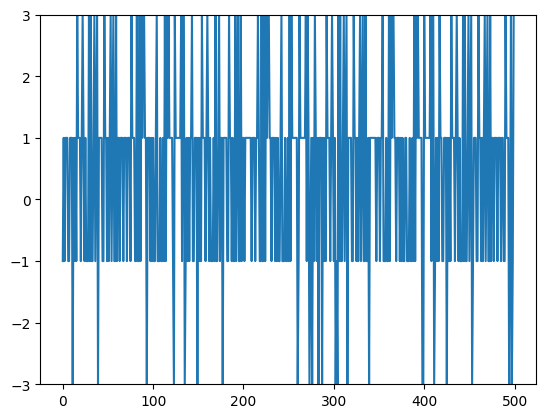

In [40]:
plt.ylim(-3, 3)
plt.plot(reward_arr[49500:50000])

In [41]:
np.mean(reward_arr[99500:100000])

1.036

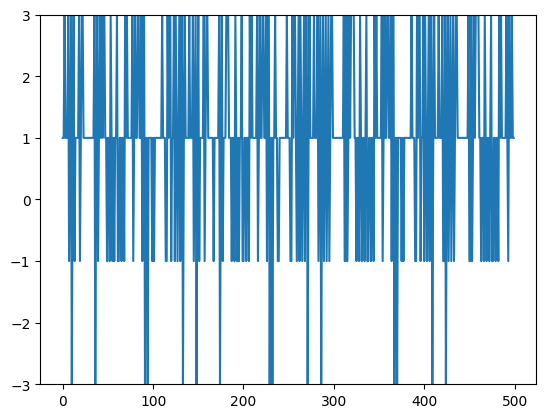

In [42]:
plt.ylim(-3, 3)
plt.plot(reward_arr[99500:100000])